In [5]:
# -----------------------------
# Cell 1: Setup paths
# -----------------------------
import sys
from pathlib import Path

# Notebook location
notebook_path = Path().resolve()  # current notebook folder
project_root = notebook_path.parent  # Notebook/ -> project root
src_path = project_root / "src"

# Add to Python path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(project_root))

print("Notebook path:", notebook_path)
print("Project root:", project_root)
print("SRC path:", src_path)

Notebook path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\notebooks
Project root: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment
SRC path: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\src


In [39]:
# -----------------------------------------------------------------------------------
# Task 3: Correlation between news sentiment and stock price movements
# -----------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import nltk

# Ensure NLP resources are available
nltk.download("vader_lexicon")
nltk.download("stopwords")
nltk.download("wordnet")

# Utils
from fns_project.utils.notebook_bootstrap import (
    logger, 
    ASSETS, 
    PLOTS_DIR,
)

# Data loaders
from fns_project.data.loader import load_news, load_prices

# Alignment functions
from fns_project.analysis.news_sentiment import align_news_to_trading_days
# (old one also exists: from fns_project.data.align_dates import align_news_to_trading_days)

# Sentiment scoring
from fns_project.analysis.sentiment import add_sentiment_columns

# Sentiment feature engineering
from fns_project.features.sentiment_features import (
    aggregate_daily_sentiment,
    add_rolling_sentiment,
    add_lagged_sentiment,
    
)

# Correlation engine
from fns_project.analysis.correlation import correlation_with_returns

# Visualization
from fns_project.viz.plots import (
    plot_daily_sentiment,
    plot_lagged_correlation,
    plot_returns_vs_sentiment, plot_sentiment_vs_returns
)

print("All modules imported successfully.")

All modules imported successfully.


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
# -----------------------------
# Cell 3: Load input data
# -----------------------------
PROCESSED_DIR = (project_root / "data/processed").resolve()
news_file = PROCESSED_DIR / "news" / "news_clean.csv"


logger.info(f"Using news file: {news_file}")

news_df = load_news(news_file)


logger.info(f"Loaded news: {len(news_df)} rows")


2025-11-27 10:55:15,345 INFO Using news file: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\news\news_clean.csv
2025-11-27 10:55:15,345 [INFO] notebook: Using news file: D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\news\news_clean.csv
2025-11-27 10:55:17,247 INFO Loaded news (55987 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\news\news_clean.csv
2025-11-27 10:55:17,247 [INFO] fns_project.data.loader: Loaded news (55987 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\news\news_clean.csv
2025-11-27 10:55:17,325 INFO Loaded news: 55987 rows
2025-11-27 10:55:17,325 [INFO] notebook: Loaded news: 55987 rows


In [28]:
# -----------------------------
# : Load all price data for ASSETS
# -----------------------------
all_prices = {}

for ticker in ASSETS:
    PROCESSED_DIR = (project_root / "data/processed").resolve()
    price_file = PROCESSED_DIR / "prices" / f"{ticker}_features.csv"

    # Load raw price CSV
    df = load_prices(price_file)

    # Store cleaned DataFrame
    all_prices[ticker] = df

    logger.info(f"{ticker}: {len(df)} rows loaded")

# Preview first ticker
price_df = all_prices[ASSETS[0]]
price_df.head(5)

2025-11-27 11:09:29,088 INFO Loaded prices (3741 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AAPL_features.csv
2025-11-27 11:09:29,088 [INFO] fns_project.data.loader: Loaded prices (3741 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AAPL_features.csv
2025-11-27 11:09:29,092 INFO AAPL: 3741 rows loaded
2025-11-27 11:09:29,092 [INFO] notebook: AAPL: 3741 rows loaded
2025-11-27 11:09:29,311 INFO Loaded prices (3741 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AMZN_features.csv
2025-11-27 11:09:29,311 [INFO] fns_project.data.loader: Loaded prices (3741 rows) from D:\10Acadamy\Week 1\Task\Predicting-Price-Moves-with-News-Sentiment\data\processed\prices\AMZN_features.csv
2025-11-27 11:09:29,320 INFO AMZN: 3741 rows loaded
2025-11-27 11:09:29,320 [INFO] notebook: AMZN: 3741 rows loaded
2025-11-27 11:09:29,509 INFO Loaded prices

,date,Close,High,Low,Open,Volume,daily_return,log_return,SMA_20,EMA_20,...,MACD_hist_12_26_9,BB_upper,BB_middle,BB_lower,ATR_14,STOCH_K,STOCH_D,ATR_20,ROLL_VOL_20,REAL_VOL_20
0,2009-02-20,2.735183,2.771173,2.669203,2.681199,750316000,0.006178,0.006159,2.829070,2.811611,...,-0.035672,3.057689,2.829070,2.600451,0.109861,22.482578,34.444605,NaN,NaN,NaN
1,2009-02-23,2.607722,2.759177,2.594526,2.748680,786982000,-0.046601,-0.047721,2.826956,2.792193,...,-0.045372,3.062827,2.826956,2.591085,0.113775,10.440469,21.092608,NaN,NaN,NaN
2,2009-02-24,2.706692,2.725886,2.609221,2.622717,807105600,0.037953,0.037250,2.827870,2.784050,...,-0.043431,3.061719,2.827870,2.594022,0.114088,13.886946,15.603331,NaN,NaN,NaN
3,2009-02-25,2.733984,2.786768,2.676701,2.694996,833053200,0.010083,0.010033,2.828515,2.779281,...,-0.038772,3.061250,2.828515,2.595780,0.113801,17.849089,14.058834,NaN,NaN,NaN
4,2009-02-26,2.674901,2.786768,2.668004,2.759176,629868400,-0.021610,-0.021847,2.821003,2.769341,...,-0.038077,3.063195,2.821003,2.578810,0.114156,22.377049,18.037695,NaN,NaN,NaN


In [29]:
# Add sentiment scores to each headline
news_scored = add_sentiment_columns( news_df, headline_col="headline" )

logger.info("Sentiment columns added.")
news_scored.head()

2025-11-27 11:10:19,390 INFO Sentiment columns added.
2025-11-27 11:10:19,390 [INFO] notebook: Sentiment columns added.


,Unnamed: 0,headline,url,publisher,date,stock,headline_len_chars,headline_word_count,headline_char_per_word,vader_neg,vader_neu,vader_pos,vader_compound,textblob_polarity,textblob_subjectivity,sentiment_ensemble,hour
0,357064,etfs watch april 28 2011 dgp ieo prn idx,https://www.benzinga.com/etfs/bond-etfs/11/04/...,ETF Professor,2011-04-28,DGP,40,9,4.444444,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.000000,1
1,437774,new regional emerging markets etf,https://www.benzinga.com/etfs/emerging-market-...,Sam Subramanian,2011-04-28,ESR,33,5,6.600000,0.000,1.000,0.000,0.0000,0.136364,0.454545,0.040909,17
2,350150,dejour extends credit facility october 31st fa...,https://www.benzinga.com/news/11/04/1041764/de...,Theo Kratz,2011-04-28,DEJ,64,11,5.818182,0.172,0.492,0.336,0.2500,0.000000,0.000000,0.175000,19
3,49280,etf showdown crouching tigers hidden etfs,https://www.benzinga.com/etfs/emerging-market-...,ETF Professor,2011-04-29,AIA,41,6,6.833333,0.000,1.000,0.000,0.0000,-0.166667,0.333333,-0.050000,17
4,539428,gdl fund redeem outstanding 8 50 series cumula...,https://www.benzinga.com/news/11/04/1045464/th...,Benzinga Staff,2011-04-29,GDL,76,11,6.909091,0.000,0.563,0.437,0.7351,0.500000,0.875000,0.664570,20


In [30]:
# Map every news headline to a trading day
news_aligned = align_news_to_trading_days(
   news_scored,
    price_df,
    news_date_col="date",
    price_date_col="date",
)

logger.info(f"Aligned news shape: {news_aligned.shape}")
news_aligned.head()

2025-11-27 11:10:19,707 INFO Aligned 55987 news rows to trading calendar (map_rule=next).
2025-11-27 11:10:19,707 [INFO] fns_project.data.align_dates: Aligned 55987 news rows to trading calendar (map_rule=next).
2025-11-27 11:10:19,710 INFO Aligned news shape: (55987, 18)
2025-11-27 11:10:19,710 [INFO] notebook: Aligned news shape: (55987, 18)


,Unnamed: 0,headline,url,publisher,date,stock,headline_len_chars,headline_word_count,headline_char_per_word,vader_neg,vader_neu,vader_pos,vader_compound,textblob_polarity,textblob_subjectivity,sentiment_ensemble,hour,trading_date
0,357064,etfs watch april 28 2011 dgp ieo prn idx,https://www.benzinga.com/etfs/bond-etfs/11/04/...,ETF Professor,2011-04-28,DGP,40,9,4.444444,0.000,1.000,0.000,0.0000,0.000000,0.000000,0.000000,1,2011-04-28
1,437774,new regional emerging markets etf,https://www.benzinga.com/etfs/emerging-market-...,Sam Subramanian,2011-04-28,ESR,33,5,6.600000,0.000,1.000,0.000,0.0000,0.136364,0.454545,0.040909,17,2011-04-28
2,350150,dejour extends credit facility october 31st fa...,https://www.benzinga.com/news/11/04/1041764/de...,Theo Kratz,2011-04-28,DEJ,64,11,5.818182,0.172,0.492,0.336,0.2500,0.000000,0.000000,0.175000,19,2011-04-28
3,49280,etf showdown crouching tigers hidden etfs,https://www.benzinga.com/etfs/emerging-market-...,ETF Professor,2011-04-29,AIA,41,6,6.833333,0.000,1.000,0.000,0.0000,-0.166667,0.333333,-0.050000,17,2011-04-29
4,539428,gdl fund redeem outstanding 8 50 series cumula...,https://www.benzinga.com/news/11/04/1045464/th...,Benzinga Staff,2011-04-29,GDL,76,11,6.909091,0.000,0.563,0.437,0.7351,0.500000,0.875000,0.664570,20,2011-04-29


In [21]:
# -----------------------------------------------------------
# Cell X+2: Aggregate daily sentiment
# -----------------------------------------------------------
daily_sentiment = aggregate_daily_sentiment(
    news_aligned,
    date_col="date",
    sentiment_col="sentiment_ensemble"
)

daily_sentiment.head()

,news_count,sentiment_mean,sentiment_median,sentiment_std
date,,,,
2011-04-28,3,0.071970,0.040909,0.091541
2011-04-29,2,0.307285,0.307285,0.505277
2011-04-30,1,0.291610,0.291610,0.000000
2011-05-01,1,0.000000,0.000000,0.000000
2011-05-02,9,0.090881,0.000000,0.118765


In [22]:
daily_sentiment = add_rolling_sentiment(
    daily_sentiment,
    window_sizes=[3, 5, 7]
)

daily_sentiment = add_lagged_sentiment(
    daily_sentiment,
    lags=[1, 2, 3, 4, 5]
)

daily_sentiment.head()


,news_count,sentiment_mean,sentiment_median,sentiment_std,sentiment_mean_roll_mean_3,sentiment_mean_roll_std_3,sentiment_mean_roll_mean_5,sentiment_mean_roll_std_5,sentiment_mean_roll_mean_7,sentiment_mean_roll_std_7,sentiment_mean_lag_1,sentiment_mean_lag_2,sentiment_mean_lag_3,sentiment_mean_lag_4,sentiment_mean_lag_5
date,,,,,,,,,,,,,,,
2011-04-28,3,0.071970,0.040909,0.091541,0.071970,0.000000,0.071970,0.000000,0.071970,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
2011-04-29,2,0.307285,0.307285,0.505277,0.189627,0.166393,0.189627,0.166393,0.189627,0.166393,0.071970,0.000000,0.000000,0.00000,0.0
2011-04-30,1,0.291610,0.291610,0.000000,0.223622,0.131568,0.223622,0.131568,0.223622,0.131568,0.307285,0.071970,0.000000,0.00000,0.0
2011-05-01,1,0.000000,0.000000,0.000000,0.199632,0.173064,0.167716,0.155054,0.167716,0.155054,0.291610,0.307285,0.071970,0.00000,0.0
2011-05-02,9,0.090881,0.000000,0.118765,0.127497,0.149213,0.152349,0.138607,0.152349,0.138607,0.000000,0.291610,0.307285,0.07197,0.0


In [31]:
daily_sentiment.index = pd.to_datetime(daily_sentiment.index).normalize()
price_df.index = pd.to_datetime(price_df.index).normalize()

In [33]:
merged_df = daily_sentiment.merge(
    price_df[['daily_return']],
    left_index=True,
    right_index=True,
    how='inner'
)
merged_df.head()

,news_count,sentiment_mean,sentiment_median,sentiment_std,sentiment_mean_roll_mean_3,sentiment_mean_roll_std_3,sentiment_mean_roll_mean_5,sentiment_mean_roll_std_5,sentiment_mean_roll_mean_7,sentiment_mean_roll_std_7,sentiment_mean_lag_1,sentiment_mean_lag_2,sentiment_mean_lag_3,sentiment_mean_lag_4,sentiment_mean_lag_5,daily_return
date,,,,,,,,,,,,,,,,
2011-04-28,3,0.071970,0.040909,0.091541,0.071970,0.000000,0.071970,0.000000,0.071970,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009710
2011-04-29,2,0.307285,0.307285,0.505277,0.189627,0.166393,0.189627,0.166393,0.189627,0.166393,0.071970,0.000000,0.000000,0.000000,0.000000,0.009748
2011-05-02,9,0.090881,0.000000,0.118765,0.127497,0.149213,0.152349,0.138607,0.152349,0.138607,0.000000,0.291610,0.307285,0.071970,0.000000,-0.010997
2011-05-03,3,0.000000,0.000000,0.000000,0.030294,0.052470,0.137955,0.152120,0.126958,0.138701,0.090881,0.000000,0.291610,0.307285,0.071970,0.005545
2011-05-05,3,-0.029867,0.000000,0.051731,0.020338,0.062891,0.070525,0.131643,0.104554,0.139804,0.000000,0.090881,0.000000,0.291610,0.307285,-0.008067


In [37]:
corr_df = correlation_with_returns(
    sentiment_df=merged_df,
    price_df=merged_df,  # daily_return already in merged_df
    sentiment_col="sentiment_mean",
    returns_col="daily_return",
    max_lag=5,
    return_pvalues=True
)
print(corr_df)

2025-11-27 11:15:06,655 INFO Correlation analysis complete (0 to 5 lags).
2025-11-27 11:15:06,655 [INFO] notebook: Correlation analysis complete (0 to 5 lags).


     correlation     n   p_value
lag                             
0       0.039262  2222  0.064256
1       0.004382  2221  0.836492
2       0.028533  2220  0.178982
3       0.023655  2219  0.265344
4      -0.004176  2218  0.844162
5      -0.001224  2217  0.954063


2025-11-27 11:15:46,784 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-27 11:15:46,784 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-27 11:15:46,822 INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-27 11:15:46,822 [INFO] matplotlib.category: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


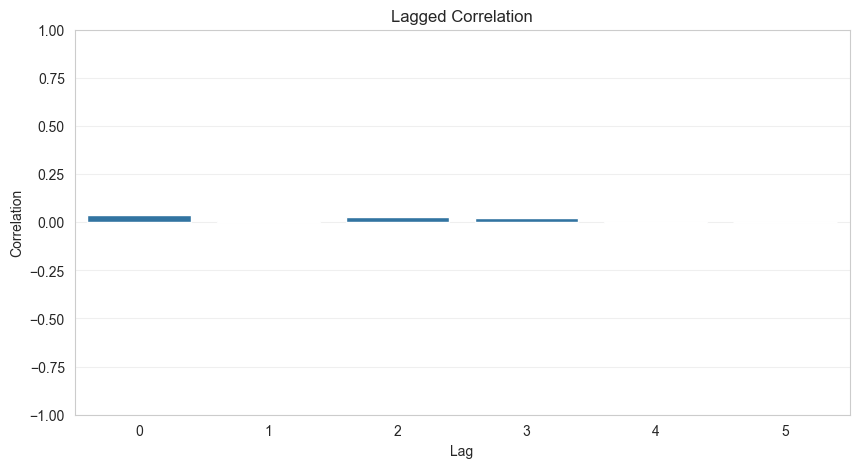

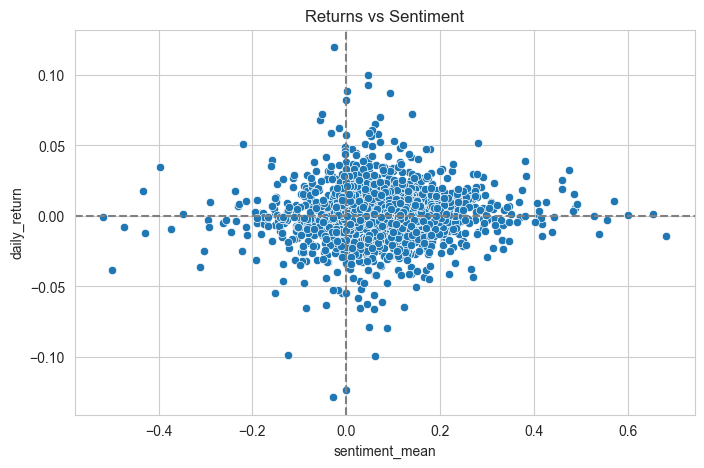

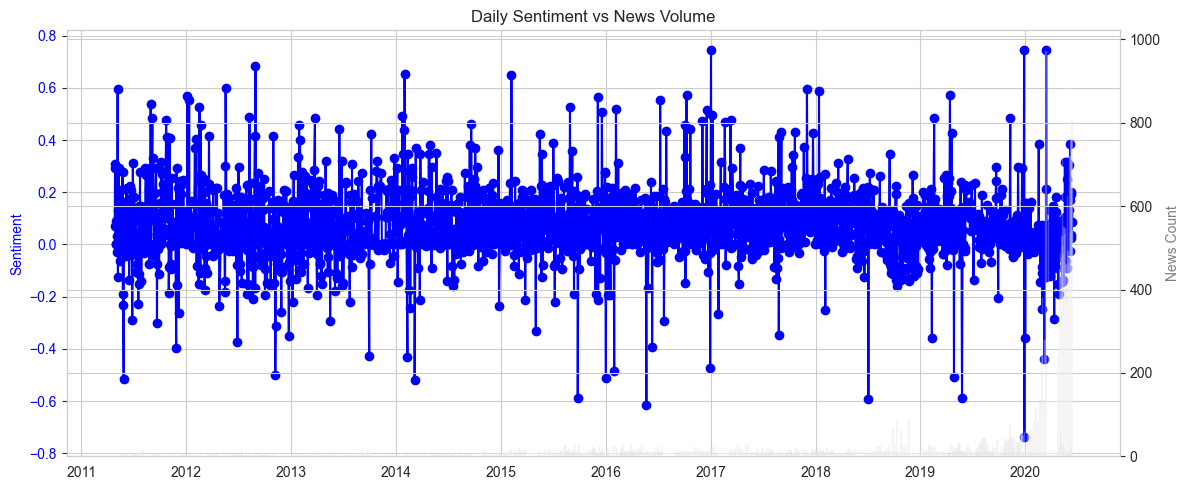

In [38]:
# 1️⃣ Plot the lagged correlations
plot_lagged_correlation(
    corr_df, correlation_col="correlation", figsize=(10, 5))

# 2️⃣ Scatter plot of returns vs same-day sentiment
plot_returns_vs_sentiment(
    merged_df,
    sentiment_col="sentiment_mean",  # or "sentiment_ensemble" if you used that
    returns_col="daily_return",
    figsize=(8, 5)
)

# 3️⃣ Optional: Plot rolling sentiment over time to see trends
plot_daily_sentiment(
    daily_sentiment,
    sentiment_col="sentiment_mean",
    count_col="news_count",
    figsize=(12, 5)
)

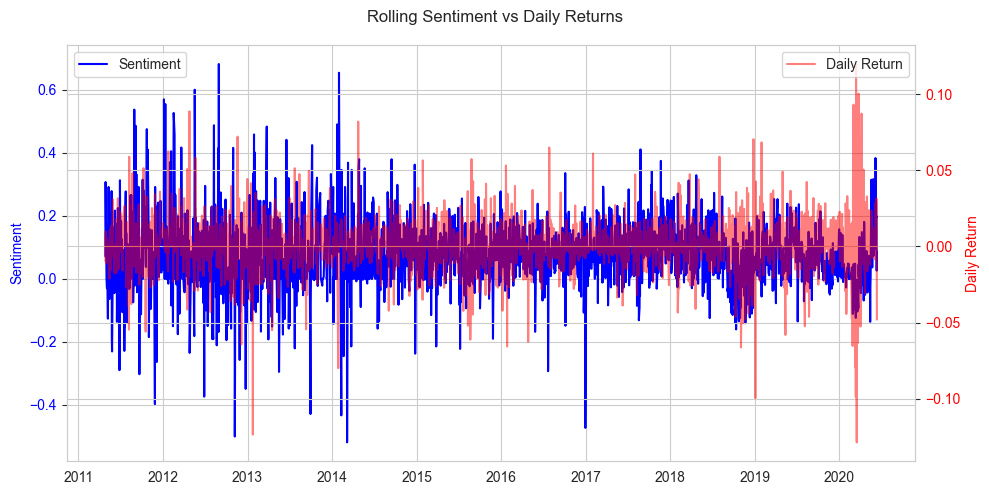

In [40]:
plot_sentiment_vs_returns(
    merged_df,
    sentiment_col="sentiment_mean",
    returns_col="daily_return",
    figsize=(10, 5)
)